### Ptychography

**Roberto dos Reis**<br>
Northwestern University

July/2020

#### References:

[1] Hoppe, W. Beugung im inhomogenen Primärstrahlwellenfeld. I. Prinzip einer Phasenmessung von Elektronenbeungungsinterferenzen. Acta Cryst. A 25, 495–501 (1969).

[2] Rodenburg, J. M. & Bates, R. H. T. The Theory of Super-Resolution Electron Microscopy Via Wigner-Distribution Deconvolution. Philos. Trans. R. Soc. A Math. Phys. Eng. Sci. 339, 521–553 (1992).

[3] Rodenburg, J. M., McCallum, B. C. & Nellist, P. D. Experimental tests on double-resolution coherent imaging via
        STEM. Ultramicroscopy 48, 304–314 (1993).
        
        
Code below is based on "A phase retrieval algorithm for shifting illumination" J.M. Rodenburg and H.M.L Faulkner, [App. Phy. Lett.  85.20 (2004)]
        


In [14]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg

In [30]:
def ePIE(n, diffSet, probe, objectSize, positions,illu_indy,illu_indx ):

    # size of probe and diffraction patterns
    ysize, xsize = probe.shape
        
    # initialize object. make sure it can hold complex numbers
    objectFunc = np.ones(objectSize, dtype=np.complex64)
    
    # initalize that illuminated part of the object
    objectIlluminated = np.ones(shape=(ysize, xsize),dtype=np.complex64)
    
    # initialize algorithm wave fields (fourier and real) 
    g = np.zeros(( ysize, xsize),dtype=np.complex64)
    gprime = np.zeros(( ysize, xsize),dtype=np.complex64)
    G = np.zeros(( ysize, xsize),dtype=np.complex64)
    Gprime = np.zeros(( ysize, xsize),dtype=np.complex64)

    # define iteration counter for outer loop
    k = 0
    
    # figure for animation
    fig = plt.figure()
    
    # Initialize vector for animation data
    ims = []
    
    # initialize vector for error calculation
    # sse = np.zeros(shape=(n,1))
    
    # idex for iterating through the diffraction patterns
    diffSetIndex = 0
    
    # Start of ePIE iterations
    while k < n:
        # Start of inner loop: (where you iterate through all probe positions R)
        for pos in positions:
        
             # Cut out the part of the image that is illuminated at R(=(ypos,xpos)
             objectIlluminated = objectFunc[pos[0]+illu_indy, pos[1]+illu_indx ]

             # Guessed wave field from the object at position R 
             g = objectIlluminated * probe      
        
             # fft the wave field at position R to Fourier space
             G = (fft.fftshift(fft.fft2(g)))
            
             # make |PSI| confirm with the diffraction pattern from R
             Gprime = np.sqrt(abs(diffSet[diffSetIndex]))*np.exp(1j*np.angle(G))
             
             # inverse Fourier transform  
             gprime =  fft.ifft2(fft.ifftshift(Gprime))
     
             # update the TOTAL object function with the illuminated part
             # The update should be the differens of the last iteration and the new one 
             alpha = 1 #higher value == faster change
             objectFunc[pos[0]+illu_indy, pos[1]+illu_indx] = objectIlluminated + alpha*(gprime-g) * np.conj(probe)  / (np.max(abs(probe))**2)   #probe* annars blir det att man delar med massa nollor
             
             # update probe function
             beta = 0.01 #higher value == faster change
             probe = probe + beta * (gprime-g) * np.conj(objectIlluminated)/ (np.max(abs(objectIlluminated))**2)
             
                     
             # Apply further constraints:
             # These 2 constraints are for transmission                
            
             # constrain object amplitude to 1
#             temp_Oamp = abs(objectFunc)
#             temp_Oamp[temp_Oamp>1] = 1
#             temp = np.angle(objectFunc)
#             objectFunc = temp_Oamp * np.exp(1j* temp)
#            
#             # to constraint object phase to negative or 0
#             temp_Ophase = np.angle(objectFunc)
#             temp_Ophase[temp_Ophase>0] = 0
#             objectFunc = abs(objectFunc) * np.exp(1j* temp_Ophase)
##            
             # animate
             im = plt.imshow(np.angle(objectFunc), animated=True)
             ims.append([im])

             diffSetIndex += 1
    
    
        k += 1        
        print('Iteration %d starts'%k)
        
        #SSE[0][k] =  sum(sum(abs(Gprime - diffSet[3] )**2 ))
        
        #reset inner loop index
        diffSetIndex = 0
       
    # End of iterations
    print('End of iterations')
    
    #todo calculate average error
#     err = np.sum( abs(diffSet[-1]**2 - G**2 )**2)
    
    # animate reconstruction 
#     ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,repeat_delay=3000)
    
    # save animation
    # .mp4 requires mencoder or ffmpeg to be installed
    #ani.save('ePIE.gif')
    #print('Saving animation')
    
    #show animation
#     plt.show()
    
    return objectFunc, probe, err

In [19]:
# create sim probe and object.
# load image and set to object phase or amplitude values

def image():
    
    #probe = mpimg.imread('circle.png')
    probe = np.zeros((256,256))
    #probe = np.ones((128,128))
    #probe[110:147, 110:147] = 1
    probe[100:157, 100:157] = 1
    
    obj = mpimg.imread('fruit.jpg')

    return probe,obj

probe, obj = image()

probe not 3d. OK
obj not 3d. OK


Text(0.5, 1.0, 'Phase')

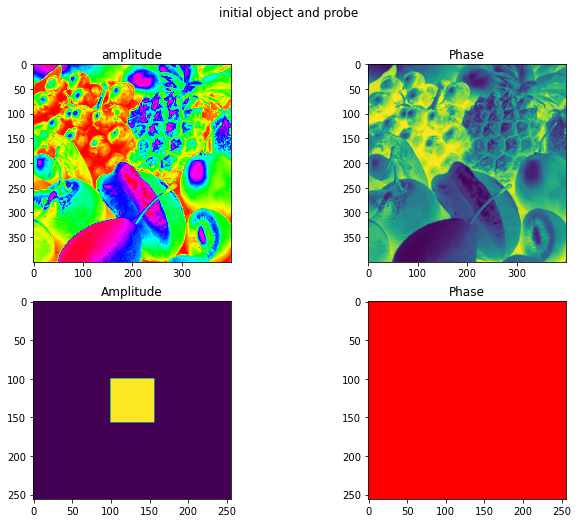

In [26]:
# collapse to 3d matrix
try:
    probe = np.array(np.sum(probe, axis=2))
except Exception:
    print('probe not 3d. OK')
try:
    obj = np.array(np.sum(obj, axis=2))
except Exception:
    print('obj not 3d. OK')


# pad image and make them complex 
padding = 0
probe = np.pad(probe, ((padding,padding),(padding,padding)), 'constant', constant_values=(0, 0))
obj = np.pad(obj, ((padding,padding),(padding,padding)), 'constant', constant_values=(0, 0))

# normalize amplitude to 1
obj = obj /obj.max()

#make object only phase (intstead of only amplitude)
#(comment out for amplitude object)
obj = 1.0 * np.exp(obj*1j) 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8),gridspec_kw={'wspace': 0}); 
plt.suptitle('initial object and probe'); 

ax1.imshow((np.abs(obj)),cmap='hsv'); 
ax1.set_title('amplitude')

ax2.imshow(np.angle(obj))
ax2.set_title('Phase')

ax3.imshow(abs(probe))
ax3.set_title('Amplitude')

ax4.imshow(np.angle(probe),cmap='hsv')
ax4.set_title('Phase')

In [27]:
#------------------------------------------------
#define scanning positions in terms of pixels
#------------------------------------------------

origin = 20
Ny = 10
Nx = 10

# overlapp shild be 60% stepsize = int(probeSize * 0.4)   #for 60% overlapp
dy = 10
dx = dy #same
positions = np.zeros((Ny*Nx,2),dtype=np.int32)

#y positions in 1st colum
positions[:, 1] = np.tile(np.arange(Nx)*dx, Ny)

#y positions in 1st colum
positions[:, 0] = np.repeat(np.arange(Ny)*dy , Nx)  
positions += origin

print('Scanning positions defined')

Scanning positions defined


Diffraction patterns created


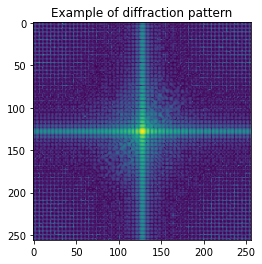

In [28]:
# make a set of diffraction patterns  

# a list of diffraction patterns
diff_set = []

# the indices for the area that is illuminated by the probe (should have the probes shape)
illu_indy, illu_indx = np.indices((probe.shape) )

# create a diffraction pattern at each probe position
for pos in positions:   
    # Propagate (obj*probe) to far field with a Fourier transform, then calculate the absolute square
    diff_set.append(abs(fft.fftshift(fft.fft2( obj[pos[0]+illu_indy, pos[1]+illu_indx]*probe)))**2 )
  

print('Diffraction patterns created')
plt.figure();plt.title('Example of diffraction pattern')
plt.imshow(abs(np.log10(diff_set[-1])))    

Iteration 1 starts
Iteration 2 starts
Iteration 3 starts
End of iterations
Error of last frame 1.2212815251313615e+29


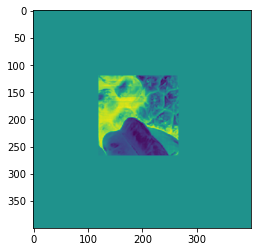

In [31]:
# Run ePIE reconstruction
#----------------------------------

#define object shape (needed  for ePIE function)
object_shape = obj.shape   # ex (34,34)

# number of iterations in ePIE
k = 3
# run the algoritm
objectFunc, probe_ret, err = ePIE(k,diff_set,probe,object_shape, positions,illu_indy,illu_indx) 
print('Error of last frame',err)

Text(0.5, 1.0, 'Phase probe')

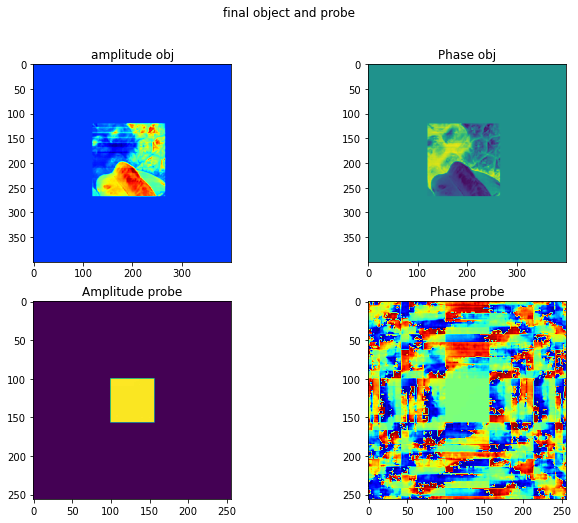

In [33]:
# image the result
#----------------------------------

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8), gridspec_kw={'wspace': 0})
plt.suptitle('Final object and probe') 

ax1.imshow((np.abs(objectFunc)),cmap='jet')
ax1.set_title('amplitude obj')

ax2.imshow(np.angle(objectFunc))
ax2.set_title('Phase obj')

ax3.imshow(abs(probe_ret))
ax3.set_title('Amplitude probe')

ax4.imshow(np.angle(probe_ret),cmap='jet')
ax4.set_title('Phase probe')